In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder  
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
USELESS_DATA_BOUNDARY= 0.3
FEATURE_FILTER_BOUNDARY = 0.05

In [4]:
class DataSet(object):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)
        self.processed_data = self.data

        #self.raw_predictor = self.data.iloc[:,:-1].values
        #self.raw_response = self.data.iloc[:,-1].values

        self.useless_value_process()
        self.missing_value_process()
        self.tag_transfer()
        self.imputer_process()
        #self.normalize()
        self.feature_filter()

    def useless_value_process(self):
        col_del = ['examide', 'citoglipton', 'glimepiride-pioglitazone','encounter_id','patient_nbr']
        self.processed_data.drop(col_del, axis=1, inplace = True)
    
    def missing_value_process(self):
        row_num = len(self.data)
        col_num = len(self.data.columns)
        cols_to_drop = []
        # Check all the features
        for col in range(col_num):
            # qm is short for Question Mark, which indicates a missing value
            qm_num = 0
            for row in range(row_num):
                # Check if the value is missing
                if str(self.data.iat[row,col]) == "?":
                    qm_num += 1

            # Print(qm_num/row_num), the percentage of missing values
            if qm_num/row_num >= USELESS_DATA_BOUNDARY:
                # Print("true") if the percentage is greater than the set boundary, and add the column to columns to drop
                cols_to_drop.append(self.data.columns[col])
        # Drop column
        self.processed_data.drop(columns=cols_to_drop, axis=1, inplace = True)

    def imputer_process(self):
        # Replace the question marks with the most frequently appeared value for each feature
        imp = SimpleImputer(missing_values= -1, strategy='most_frequent')
        imp.fit(self.processed_data)

    def tag_transfer(self): 

        le = LabelEncoder()
        #self.processed_data.replace('?', -1, inplace=True)
        value_to_keep = "?"

        # 遍历DataFrame的每一列
        for column in self.processed_data.columns:
            # 如果列的数据类型是对象（通常意味着它是分类类型）
            if self.processed_data[column].dtype == 'object':
                # 对列应用 LabelEncoder
                values_to_encode = self.processed_data[column] != value_to_keep
                #original_column = self.processed_data[column].copy()
                # 对非特定值应用 LabelEncoder
                encoded_values = le.fit_transform(self.processed_data.loc[values_to_encode, column])
                self.processed_data[column] = le.fit_transform(self.processed_data[column])
                self.processed_data[column].fillna(self.processed_data[column], inplace=True)


    def get_integer_mapping(self, le):
    
        res = {}
    
        for cl in le.classes_:
    
            res.update({cl:le.transform([cl])[0]})
    
        return res

    def normalize(self):

        # Normalize data using StandardScaler
        scaler = StandardScaler()
        normalized_data = scaler.fit_transform(self.processed_data)

        # Print normalized data
        print(normalized_data)

    def feature_filter(self):
        importances = self.processed_data.drop('readmitted', axis=1).apply(lambda x: x.corr(self.processed_data.readmitted))
        indices = np.argsort(importances)
        print(importances[indices])

        names=[]
        for col in self.processed_data.columns:
            names.append(col)
        names.remove("readmitted")

        # plt.title('Readmitted')
        # plt.barh(range(len(indices)), importances[indices], color='g', align='center')
        # plt.yticks(range(len(indices)), [names[i] for i in indices])
        # plt.xlabel('Relative Importance')
        # plt.show()

        for i in range(0, len(indices)):
            if np.abs(importances[i]) > FEATURE_FILTER_BOUNDARY:
                print(names[i])

In [5]:
train_data = DataSet('diabetic_data.csv')
test_data = DataSet('diabetic_data_test.csv')

#train_data.data

#test_data.processed_data

train_data.processed_data.to_csv("test_csv.csv",index=False)

number_inpatient           -0.234283
number_diagnoses           -0.104820
number_emergency           -0.103024
number_outpatient          -0.068552
time_in_hospital           -0.057718
diabetesMed                -0.057306
num_medications            -0.051772
num_lab_procedures         -0.037976
admission_source_id        -0.031816
age                        -0.030271
repaglinide                -0.019256
race                       -0.015184
discharge_disposition_id   -0.012450
glipizide                  -0.011591
acarbose                   -0.008583
diag_3                     -0.008325
rosiglitazone              -0.006756
pioglitazone               -0.005238
A1Cresult                  -0.003312
insulin                    -0.003113
nateglinide                -0.003039
diag_2                     -0.002351
glipizide-metformin        -0.001980
acetohexamide              -0.001959
glyburide-metformin        -0.001552
troglitazone               -0.000748
chlorpropamide              0.001134
m

In [6]:
# export the normalized data as an Excel file
#df = pd.read_csv('test_csv.csv')
#df.to_excel('normalized_new_dataset.xlsx', index = False, header=True)

In [7]:
train_data = pd.read_csv('diabetic_data.csv')
test_data = pd.read_csv('diabetic_data_test.csv')

predictor = train_data.iloc[:,:-1].values
response = train_data.iloc[:,-1].values

predictor,response 

(array([[2278392, 8222157, 'Caucasian', ..., 'No', 'No', 'No'],
        [149190, 55629189, 'Caucasian', ..., 'No', 'Ch', 'Yes'],
        [64410, 86047875, 'AfricanAmerican', ..., 'No', 'No', 'Yes'],
        ...,
        [443854148, 41088789, 'Caucasian', ..., 'No', 'Ch', 'Yes'],
        [443857166, 31693671, 'Caucasian', ..., 'No', 'Ch', 'Yes'],
        [443867222, 175429310, 'Caucasian', ..., 'No', 'No', 'No']],
       dtype=object),
 array(['NO', '>30', 'NO', ..., 'NO', 'NO', 'NO'], dtype=object))

number_inpatient           -0.234283
number_diagnoses           -0.104820
number_emergency           -0.103024
number_outpatient          -0.068552
time_in_hospital           -0.057718
diabetesMed                -0.057306
num_medications            -0.051772
num_lab_procedures         -0.037976
admission_source_id        -0.031816
age                        -0.030271
repaglinide                -0.019256
race                       -0.015184
discharge_disposition_id   -0.012450
glipizide                  -0.011591
acarbose                   -0.008583
diag_3                     -0.008325
rosiglitazone              -0.006756
pioglitazone               -0.005238
A1Cresult                  -0.003312
insulin                    -0.003113
nateglinide                -0.003039
diag_2                     -0.002351
glipizide-metformin        -0.001980
acetohexamide              -0.001959
glyburide-metformin        -0.001552
troglitazone               -0.000748
chlorpropamide              0.001134
m

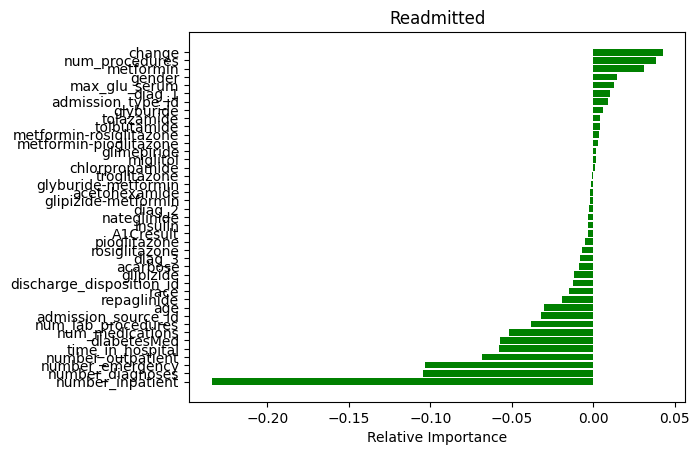

time_in_hospital
num_medications
number_outpatient
number_emergency
number_inpatient
number_diagnoses
diabetesMed


In [8]:
processed_data = pd.read_csv('test_csv.csv')
importances = processed_data.drop('readmitted', axis=1).apply(lambda x: x.corr(processed_data.readmitted))
indices = np.argsort(importances)
print(importances[indices])

names=[]
for col in processed_data.columns:
    names.append(col)
names.remove("readmitted")

plt.title('Readmitted')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

for i in range(0, len(indices)):
    if np.abs(importances[i]) > FEATURE_FILTER_BOUNDARY:
        print(names[i])